## Reinforcement Learning

process of Reinforcement Learning involves these simple steps:

    1.Observation of the environment  
    2.Deciding how to act using some strategy 
    3.Acting accordingly  
    4.Receiving a reward or penalty  
    5.Learning from the experiences and refining our strategy 
    6.Iterate until an optimal strategy is found

## Example- Self-Driving Cab

The Smartcab's job is to pick up the passenger at one location and drop them off in another. Here are a few things that we'd love our Smartcab to take care of:

* Drop off the passenger to the right location.
* Save passenger's time by taking minimum time possible to drop off
* Take care of passenger's safety and traffic rules

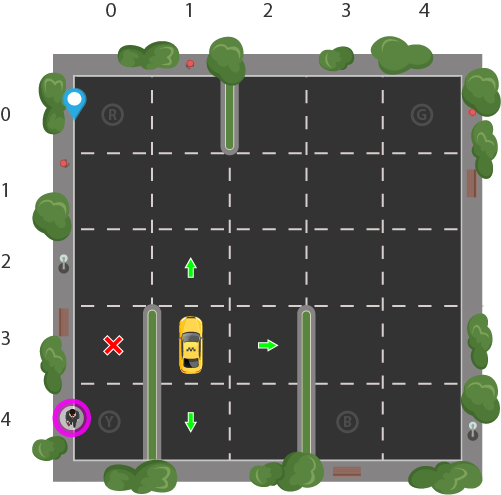

There are different aspects that need to be considered here while modeling an RL solution to this problem: rewards, states, and actions.

     1.Rewards
      - The agent should receive a high positive reward for a successful dropoff because this behavior is highly desired
      - The agent should be penalized if it tries to drop off a passenger in wrong locations
      - The agent should get a slight negative reward for not making it to the destination after every time-step. "Slight"    negative because we would prefer our agent to reach late instead of making wrong moves trying to reach to the destination as fast as possible
      
      2. State Space
        The State Space is the set of all possible situations our taxi could inhabit.
        We can break up the parking lot into a 5x5 grid, which gives us 25 possible taxi locations. 
        there's four (4) destinations and five (4 + 1) passenger locations.
        So, our taxi environment has 5x5x5x4 = 500 total possible states
        
      3.Action 
        we have six possible actions:south,north,east,west,pickup,dropoff

In [4]:
# OpenAI Gym has this exact environment already built for us

In [5]:
import gym
env = gym.make("Taxi-v3").env
env.render()

+---------+
|R: | : :G|
| : | : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+



"There are 4 locations (labeled by different letters), and our job is to pick up the passenger at one location and drop him off at another. We receive +20 points for a successful drop-off and lose 1 point for every time-step it takes. There is also a 10 point penalty for illegal pick-up and drop-off actions."

In [6]:
env.reset() # reset environment to a new, random state
env.render()

print("Action Space {}".format(env.action_space))
print("State Space {}".format(env.observation_space))

+---------+
|R: | : :G|
| : | : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+

Action Space Discrete(6)
State Space Discrete(500)


we have the taxi at row 3, column 1, our passenger is at location 2, and our destination is location 0. Using the Taxi-v2 state encoding method, we can do the following:

In [7]:
state = env.encode(3, 1, 2, 0) # (taxi row, taxi column, passenger index, destination index)
print("State:", state)

env.s = state
env.render()

State: 328
+---------+
|R: | : :G|
| : | : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+



### The Reward Table

When the Taxi environment is created, there is an initial Reward table that's also created, called `P`. We can think of it like a matrix that has the number of states as rows and number of actions as columns, i.e. a  states X actions  matrix.

In [8]:
env.P[328]

{0: [(1.0, 428, -1, False)],
 1: [(1.0, 228, -1, False)],
 2: [(1.0, 348, -1, False)],
 3: [(1.0, 328, -1, False)],
 4: [(1.0, 328, -10, False)],
 5: [(1.0, 328, -10, False)]}

## Solving the environment without Reinforcement Learning -  random moves

In [9]:
env.s = 328  # set environment to illustration's state
epochs = 0
penalties, reward = 0, 0
frames = [] # for animation
done = False

while not done:
    action = env.action_space.sample()
    state, reward, done, info = env.step(action)

    if reward == -10:
        penalties += 1
    
    # Put each rendered frame into dict for animation
    frames.append({
        'frame': env.render(mode='ansi'),
        'state': state,
        'action': action,
        'reward': reward
        }
    )

    epochs += 1
    
    
print("Timesteps taken: {}".format(epochs))
print("Penalties incurred: {}".format(penalties))

Timesteps taken: 2210
Penalties incurred: 730


In [37]:
from IPython.display import clear_output
from time import sleep

def print_frames(frames):
    for i, frame in enumerate(frames):
        clear_output(wait=True)
        print(frame['frame'])
        print(f"Timestep: {i + 1}")
        print(f"State: {frame['state']}")
        print(f"Action: {frame['action']}")
        print(f"Reward: {frame['reward']}")
        sleep(.1)
        
print_frames(frames)

+---------+
|R: | : :G|
| : | : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+
  (Dropoff)

Timestep: 2210
State: 0
Action: 5
Reward: 20


## Solving the environment with Reinforcement Learning

### Q-learning   Q-Table

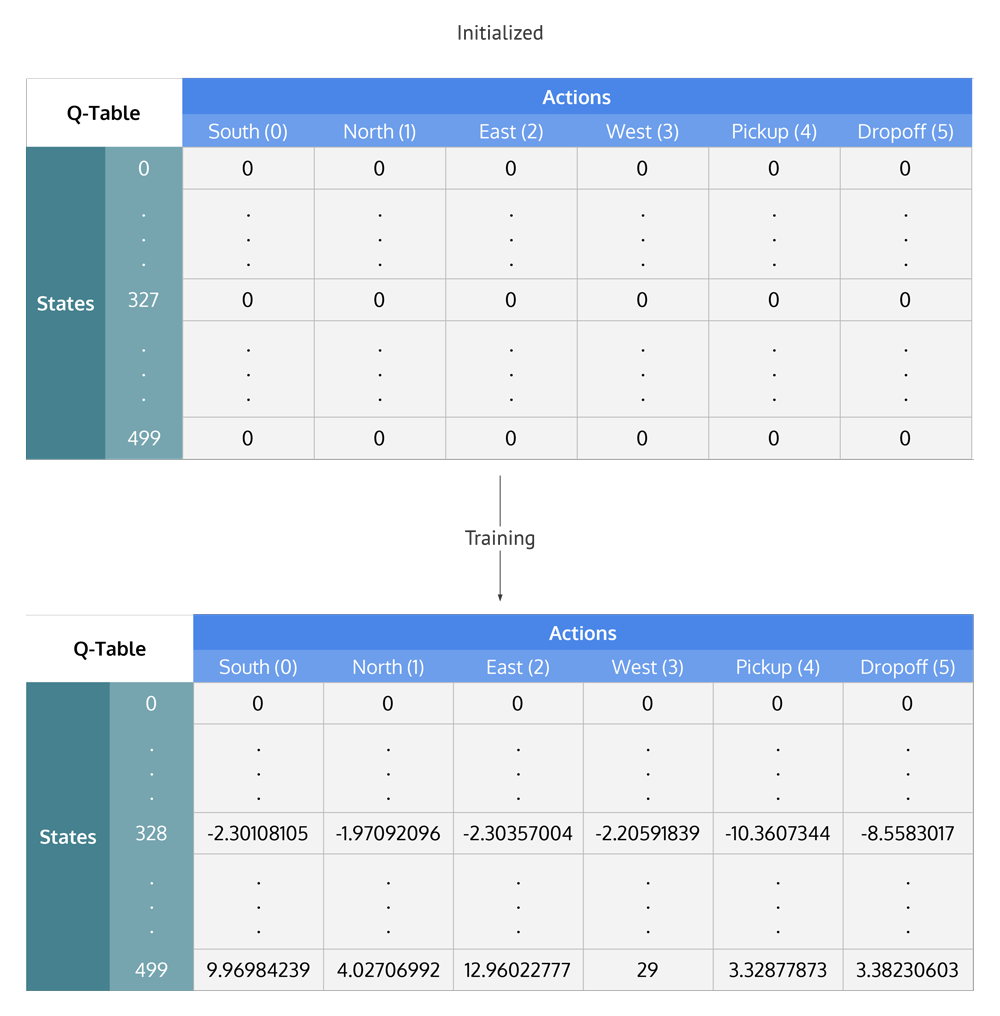

## Implementing Q-learning

* we'll initialize the Q-table to a 500X6 matrix of zeros:

In [38]:
import numpy as np
q_table = np.zeros([env.observation_space.n, env.action_space.n])

In [42]:
%%time
"""Training the agent"""

import random
from IPython.display import clear_output

# Hyperparameters
alpha = 0.1
gamma = 0.6
epsilon = 0.1

# For plotting metrics
all_epochs = []
all_penalties = []

for i in range(1, 100001):
    state = env.reset()

    epochs, penalties, reward, = 0, 0, 0
    done = False
    
    while not done:
        if random.uniform(0, 1) < epsilon:
            action = env.action_space.sample() # Explore action space
        else:
            action = np.argmax(q_table[state]) # Exploit learned values

        next_state, reward, done, info = env.step(action) 
        
        old_value = q_table[state, action]
        next_max = np.max(q_table[next_state])
        
        new_value = (1 - alpha) * old_value + alpha * (reward + gamma * next_max)
        q_table[state, action] = new_value

        if reward == -10:
            penalties += 1

        state = next_state
        
        epochs += 1
        
    if i % 100 == 0:
        clear_output(wait=True)
        print(f"Episode: {i}")

print("Training finished.\n")

Episode: 100000
Training finished.

Wall time: 1min 49s


*  the Q-table has been established over 100,000 episodes, let's see what the Q-values are at our illustration's state:

In [40]:
q_table[328]

array([ -2.4061573 ,  -2.27325184,  -2.41185217,  -2.3591524 ,
       -11.02572347, -10.81592945])

* The max Q-value is "north" (-1.971), so it looks like Q-learning has effectively learned the best action to take in our illustration's state!

### Evaluating the agent

In [46]:
"""Evaluate agent's performance after Q-learning"""

total_epochs, total_penalties = 0, 0
episodes = 100
frames2 = [] # for animation

for _ in range(episodes):
    state = env.reset()
    epochs, penalties, reward = 0, 0, 0
    
    done = False
    
    while not done:
        action = np.argmax(q_table[state])
        state, reward, done, info = env.step(action)

        if reward == -10:
            penalties += 1
        # Put each rendered frame into dict for animation
        frames2.append({
        'frame': env.render(mode='ansi'),
        'state': state,
        'action': action,
        'reward': reward
        })

        epochs += 1

    total_penalties += penalties
    total_epochs += epochs

print(f"Results after {episodes} episodes:")
print(f"Average timesteps per episode: {total_epochs / episodes}")
print(f"Average penalties per episode: {total_penalties / episodes}")

Results after 100 episodes:
Average timesteps per episode: 12.73
Average penalties per episode: 0.0


In [45]:
# from IPython.display import clear_output
# from time import sleep

# def print_frames(frames2):
#     for i, frame in enumerate(frames2):
#         clear_output(wait=True)
#         print(frame['frame'])
#         print(f"Timestep: {i + 1}")
#         print(f"State: {frame['state']}")
#         print(f"Action: {frame['action']}")
#         print(f"Reward: {frame['reward']}")
#         sleep(.1)
        
# print_frames(frames2)

+---------+
|R: | : :G|
| : | : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+
  (Dropoff)

Timestep: 463
State: 0
Action: 5
Reward: 20


KeyboardInterrupt: 

## Comparing our Q-learning agent to no Reinforcement Learning

We eluate our agents according to the following metrics,

* Average number of penalties per episode: The smaller the number, the better the performance of our agent. Ideally, we would like this metric to be zero or very close to zero.
* Average number of timesteps per trip: We want a small number of timesteps per episode as well since we want our agent to take minimum steps(i.e. the shortest path) to reach the destination.
* Average rewards per move: The larger the reward means the agent is doing the right thing. That's why deciding rewards is a crucial part of Reinforcement Learning. In our case, as both timesteps and penalties are negatively rewarded, a higher average reward would mean that the agent reaches the destination as fast as possible with the least penalties"

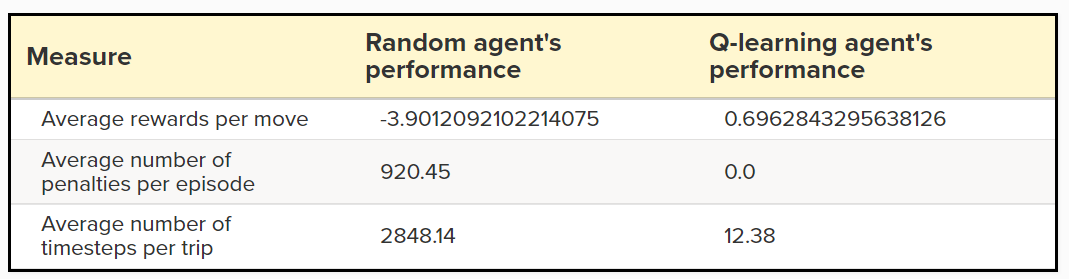